# Forecasting Air Passenger using GRU
1. In this exercise we will use **very basic LSTM units**.
    - GRU cell type = basic
    - timestep = 1
    - input feature = 1
    - #GRU layers = 1 
    - #GRU units = 3 (experimentally choosen).
    
2. GRU modeling building, forecasting and result interpretation.
3. Visualization of LSTM contribution in result prediction.
4. GRU weights variation during training.

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
from copy import copy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.models import Input, Model
from keras.layers import GRU, Dense
from keras import losses
from keras import optimizers
from keras import callbacks
from keras import initializers
from keras.models import load_model
# perosnal wrapper created for time-series plots
from ts_utils import tsplot

Using TensorFlow backend.


In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [3]:
warnings.filterwarnings("ignore")

## Basic analysis and data preparation

In [4]:
DATADIR = '../data/air-passenger/'
data_path = os.path.join(DATADIR, 'AirPassengers.csv')

CKPTDIR = '../checkpoints/air-passenger/GRU/weights/'
LOGDIR = '../checkpoints/air-passenger/GRU/logs/'
MODELDIR = '../checkpoints/air-passenger/GRU/model/'

In [5]:
df = pd.read_csv(data_path, usecols=[1], header=0, engine='python')
data = df.values
data = data.astype('float32')

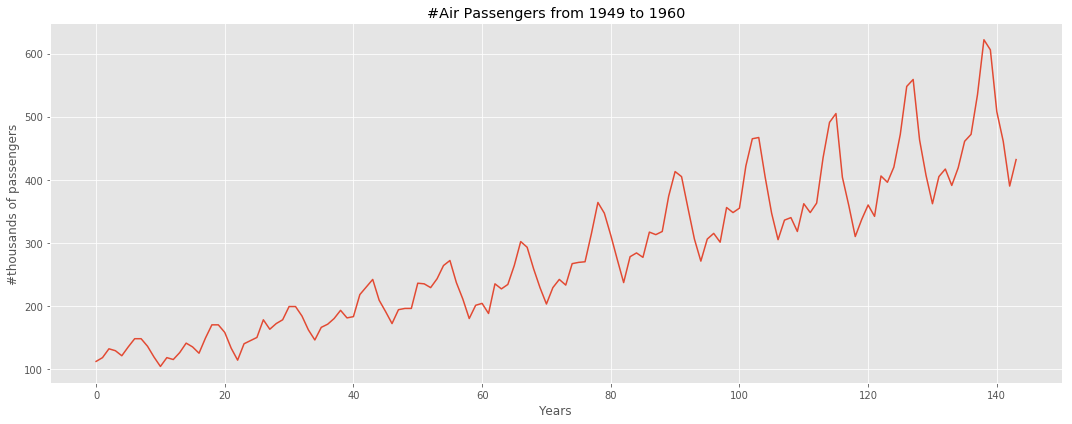

In [6]:
plt.plot(data)
plt.title('#Air Passengers from 1949 to 1960')
plt.ylabel('#thousands of passengers')
plt.xlabel('Years')
plt.tight_layout()
plt.show()

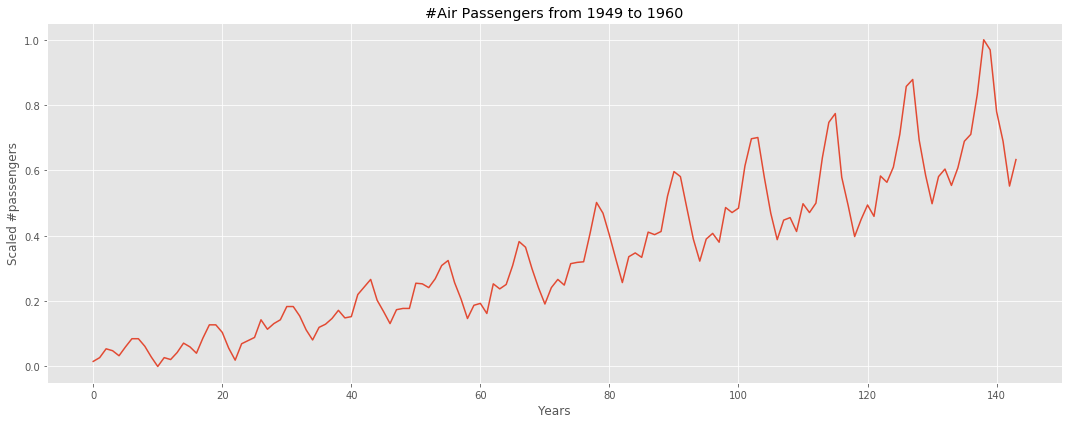

In [7]:
# ANNs are sensitive to the scale of the input data.
# So, for our analysis we will limit the data magnitude to (0, 1)

# scalar transformation
scalar = MinMaxScaler(feature_range=(0, 1))
scaled_data = scalar.fit_transform(data)

plt.plot(scaled_data)
plt.title('#Air Passengers from 1949 to 1960')
plt.ylabel('Scaled #passengers')
plt.xlabel('Years')
plt.tight_layout()
plt.show()

In [8]:
# LSTM is a superived learning algorithm so, it needs the
# input data in the form of X and Y. So, for this purpose we 
# will prepare our dataset based on time steps.
# For clarity, dependent variable is only dependent on value of
# data one step prior to it. (In this case)
# Eg. X=t, then Y=t+1

# function to prepare the TS data for LSTM
def prepare_data(data, time_step=1):
    dataX = []
    dataY = []
    for i in range(len(data)-time_step-1):
        temp = data[i:(i+time_step), 0]
        dataX.append(temp)
        dataY.append(data[i+time_step, 0])
    return np.array(dataX), np.array(dataY).reshape(-1, 1)

In [9]:
train, test = train_test_split(scaled_data, train_size=0.8 ,shuffle=False)

len(train), len(test)

X_train, y_train = prepare_data(train, time_step=1)
X_test, y_test = prepare_data(test, time_step=1)

# The length of data will be reduced 
# by the amount of time step (when time_step=1)
len(X_train), len(X_test)

# lets see some sample data
print(f'Independent variable values t: \n{X_train[:5, :]}')
print(f'Depending variable values t+1: \n{y_train[:5]}')

Independent variable values t: 
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]
Depending variable values t+1: 
[[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984557]]


## GRU model building and training

In [10]:
# LSTM need the input in the form of [#samples, time step, features]
# in this case, we are only considering the value to 't' to calculate 't+1'
# so, timesteps = 1, and as there is only one variable we will use features = 1
timesteps = 1
features = 1
batch_size = None

X_train = np.reshape(X_train, (X_train.shape[0], timesteps, features))
X_test = np.reshape(X_test, (X_test.shape[0], timesteps, features))

In [11]:
print(X_train.shape)

(113, 1, 1)


In [12]:
xavier = initializers.glorot_normal()

In [13]:
# create LSTM model
ip = Input(batch_shape=(batch_size, timesteps, features), name='input')
gru = GRU(3, activation='tanh', 
            kernel_initializer=xavier, recurrent_initializer=xavier, name='gru')(ip)
output = Dense(1, name='dense')(gru)

model = Model(inputs=ip, outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1, 1)              0         
_________________________________________________________________
gru (GRU)                    (None, 3)                 45        
_________________________________________________________________
dense (Dense)                (None, 1)                 4         
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [14]:
# compile the model
model.compile(loss=losses.mean_squared_error, optimizer=optimizers.Adam())

In [15]:
# checkpoint directory for saving model weights
if os.path.exists(LOGDIR):
    pass
else:
    os.makedirs(LOGDIR)

# log directory for tensorboard 
if os.path.exists(CKPTDIR):
    pass
else:
    os.makedirs(CKPTDIR)
    
# model directory
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

In [16]:
callbacks_list = [callbacks.ModelCheckpoint(filepath=os.path.join(CKPTDIR, "weights{epoch:03d}.hdf5")),
                  callbacks.TensorBoard(log_dir=LOGDIR)
                 ]

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=1, 
                    verbose=1,
                    shuffle=False,
                    callbacks = callbacks_list
                   )

model.save(os.path.join(MODELDIR, 'gru_v1.h5'))
model.save_weights(os.path.join(MODELDIR, 'gru_weight_v1.h5'))

Instructions for updating:
Use the retry module or similar alternatives.
Epoch 1/100
113/113 [==============================] - 1s 5ms/step - loss: 0.0315
Epoch 2/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0256
Epoch 3/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0248
Epoch 4/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0224
Epoch 5/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 6/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0170
Epoch 7/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 8/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 9/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0088
Epoch 10/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0067
Epoch 11/100
113/113 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 12/100
113/113 [=

In [17]:
# model = load_model(os.path.join(MODELDIR, 'gru_v1.h5'))
# model.load_weights(os.path.join(MODELDIR, 'gru_weight_v1.h5'))

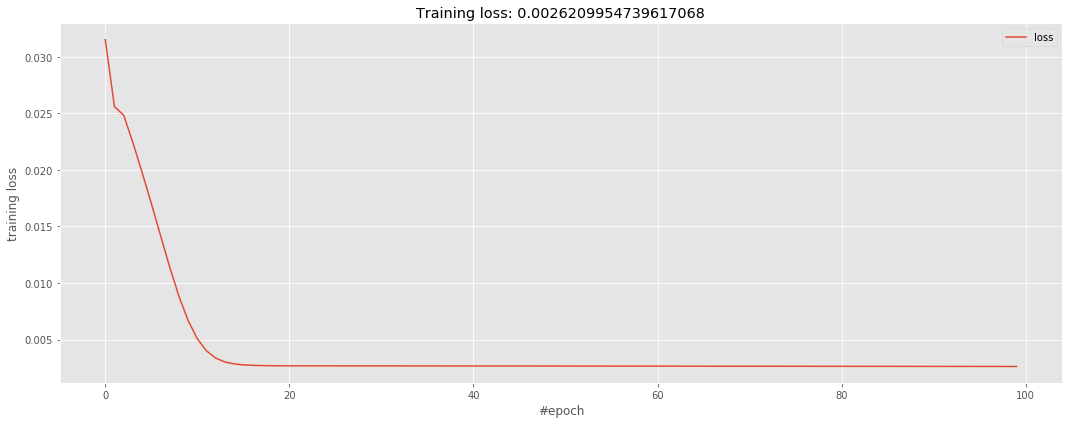

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.ylabel("training loss")
plt.xlabel("#epoch")
plt.title("Training loss: {}".format(history.history["loss"][-1]))
plt.legend()
plt.tight_layout()
plt.show()

## Prediction and result evaluation

In [19]:
# prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# the results are in the form of scaled value, so inverse the transformation
y_train_pred_inv = scalar.inverse_transform(y_train_pred)
y_test_pred_inv = scalar.inverse_transform(y_test_pred)

# will be used for calculating MAE and MSE
y_train_inv = scalar.inverse_transform(y_train)
y_test_inv = scalar.inverse_transform(y_test)

# MAE and RMSE calculation
train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
train_mae = mean_absolute_error(y_train_inv, y_train_pred_inv)
train_nrmse = train_rmse/np.std(y_train_inv)

test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
test_mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
test_nrmse = test_rmse/np.std(y_test_inv)

print(f'Training NRMSE: {train_nrmse}')
print(f'Training MAE: {train_mae}')

print(f'Test NRMSE: {test_nrmse}')
print(f'Test MAE: {test_mae}')

Training NRMSE: 0.2996988594532013
Training MAE: 20.701040267944336
Test NRMSE: 0.6402789354324341
Test MAE: 44.62099075317383


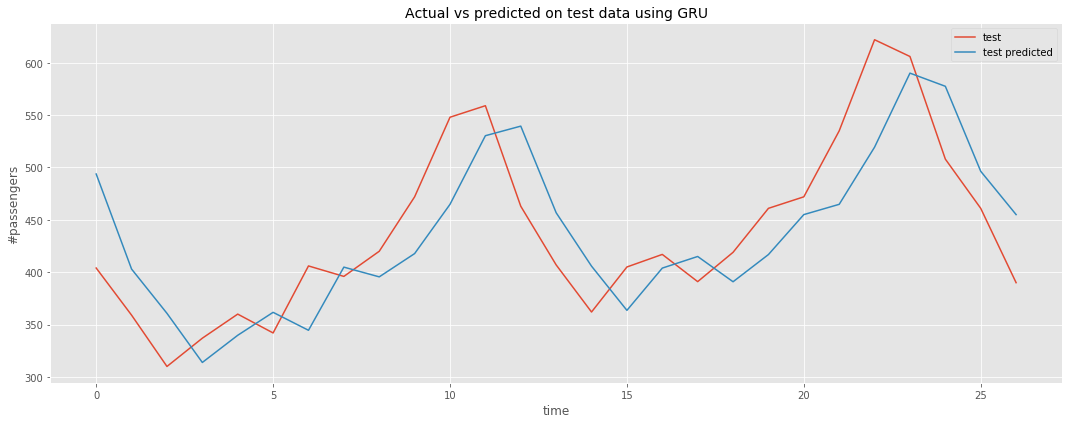

In [29]:
plt.plot(y_test_inv, label='test')
plt.plot(y_test_pred_inv, label='test predicted')
plt.ylabel('Sales')
plt.xlabel('time')
plt.ylabel('#passengers')
plt.title('Actual vs predicted on test data using GRU', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

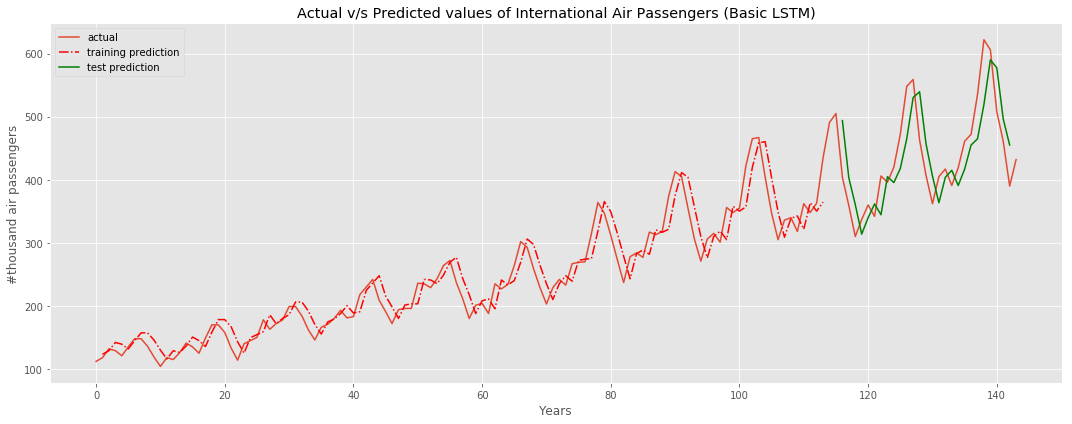

In [21]:
# plotting the results and comparision

# the prediction for LSTM will be shifted by the value of time_steps
# as 't' is used to calculate the value of 't+1', so plotting start from 't+1'
time_step=1

train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[time_step:len(y_train_pred_inv)+time_step, :] = y_train_pred_inv

# shift test predictions for plotting
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(y_train_pred_inv)+(time_step*2)+1:len(data)-1, :] = y_test_pred_inv

# result plotting
plt.plot(data, label='actual')
plt.plot(train_plot, color='red', linestyle='-.', label='training prediction')
plt.plot(test_plot, color='green', linestyle='-', label='test prediction')
plt.xlabel('Years')
plt.ylabel('#thousand air passengers')
plt.title('Actual v/s Predicted values of International Air Passengers (Basic LSTM)')

plt.legend()
plt.tight_layout()
plt.show()

## Result interpretation (GRU)

- Training RMSE: 26.028308868408203
- Training MAE: 20.64999008178711
- Test RMSE: 51.887210845947266
- Test MAE: 44.632144927978516


1. The difference in training and test set results can be accounted due to the increase in variation of data with time.
2. The result is comparable to SARIMA model result and LSTM, if not better.
3. This is the very basic GRU model used for training and prediction.
4. **Note** : the predicted values is almost shifted by a day or two. 
5. We will try to fine tune our network structure to see if it improves the performance.
6. Let's see in the visualisation below, how LSTM learn the representation behind the scence.